In [1]:
import torch
import torch.nn as nn
from Nail_dataset import get_dataset
from torch.utils.data import DataLoader
from Model import get_model
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from torch.nn.functional import binary_cross_entropy
import torch
from torch.utils.tensorboard import SummaryWriter
from loss import *

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:

def train(dataloader, model, loss_fn, optimizer, criterion, writer, epoch):
    model = model.to("cuda")
    model.train()
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    total_score = 0
    for batch, (X, y, image) in enumerate(dataloader):
        X = X.float()
        y = y.float()
        X, y = X.to(device), y.to(device)
        
        X = X.requires_grad_()
        # Compute prediction error
        pred = model(X)
        pred = F.sigmoid(pred)
        


        pred = pred.reshape(1,256,256)
        y = y.reshape(1,256,256)
        
        loss = loss_fn((pred), y)
        score = criterion((pred), y)

        total_loss+=abs(loss)
        total_score+=abs(score)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"total_loss: {total_loss:>7f}  [{current:>5d}/{size:>5d}]")
    writer.add_scalar("Loss/train", total_loss/len(dataloader), epoch)
    writer.add_scalar("IOU/train", total_score/len(dataloader), epoch)
    return total_loss

In [4]:

def valid(dataloader, model, loss_fn, optimizer, criterion, writer, epoch):
    model.eval()
    model = model.to("cpu")
    size = len(dataloader.dataset)
    total_loss = 0
    total_score = 0
    for batch, (X, y, image) in enumerate(dataloader):
        X = X.float()
        y = y.float()
        pred = model(X)
        pred = F.sigmoid(pred)
        pred = pred.reshape(1,256,256)
        y = y.reshape(1,256,256)
        loss = loss_fn((pred), y)
        score = criterion((pred), y)
        total_loss+=abs(loss)
        total_score+=abs(score)
    writer.add_scalar("Loss/val", total_loss/len(dataloader), epoch)
    writer.add_scalar("IOU/val", total_score/len(dataloader), epoch)
    return total_score

In [5]:
train_dataset = get_dataset("train", augment = False)
val_dataset = get_dataset("val", augment = False)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
model = get_model()
#resume
# model.load_state_dict(torch.load("D:/Project/Tony/anemia/code/keras_version/models/best_model.pth"))


# loss_fn = IoULoss()
loss_fn = DiceLoss()
criterion = IoUScore()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
image, mask, origin_image = next(iter(train_dataloader))

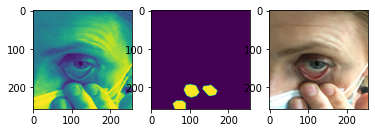

In [10]:
plt.subplot(1,3,1)
plt.imshow(image[0][0])
plt.subplot(1,3,2)
plt.imshow(mask[0][0])
plt.subplot(1,3,3)
plt.imshow(origin_image[0])

In [11]:
image.shape

torch.Size([1, 1, 256, 256])

In [ ]:
date = "runs/8_6_1"
epochs = 3000
device = 'cuda' if torch.cuda.is_available() else "cpu"
writer = SummaryWriter(date)
print(device)
max_score=0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_loss_train = train(train_dataloader, model, loss_fn, optimizer, criterion, writer, t)
    print("training loss : ", total_loss_train/len(train_dataloader))
    if(t%20==0): 
        with torch.no_grad():
            total_score_val = valid(val_dataloader, model, loss_fn, optimizer, criterion, writer, t)
            print("validation score : ", total_score_val/len(val_dataloader))
            if(total_score_val/len(val_dataloader) > max_score ):
                max_score = total_score_val/len(val_dataloader)
                print("#########save_best_model###########")
                torch.save(model.state_dict(), "D:/Project/Tony/anemia/code/keras_version/models/best_model.pth")
            torch.save(model.state_dict(), "D:/Project/Tony/anemia/code/keras_version/models/model_"+str(t)+".pth")
print("Done!")

cuda
Epoch 1
-------------------------------


C:\Users\HMILAB\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


total_loss: 0.996051  [    0/  199]
total_loss: 25.222879  [   25/  199]
total_loss: 49.540150  [   50/  199]
total_loss: 73.977951  [   75/  199]
total_loss: 98.114555  [  100/  199]
total_loss: 121.952957  [  125/  199]
total_loss: 145.766357  [  150/  199]
total_loss: 169.720871  [  175/  199]
training loss :  tensor(0.9636, device='cuda:0', grad_fn=<DivBackward0>)
validation score :  tensor(0.0211)
#########save_best_model###########
Epoch 2
-------------------------------
total_loss: 0.811484  [    0/  199]
total_loss: 24.385643  [   25/  199]
total_loss: 48.308006  [   50/  199]
total_loss: 72.163910  [   75/  199]
total_loss: 95.717888  [  100/  199]
total_loss: 119.724228  [  125/  199]
total_loss: 143.177368  [  150/  199]
total_loss: 167.107620  [  175/  199]
training loss :  tensor(0.9491, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3
-------------------------------
total_loss: 0.824808  [    0/  199]
total_loss: 24.467552  [   25/  199]
total_loss: 48.308441  [   50/  19

In [ ]:
# ls D:\Project\Tony\anemia\code\keras_version

In [ ]:
torch.save(model.state_dict(), "D:/Project/Tony/anemia/code/keras_version/best_model_equalizehist.pth")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
# model.load_state_dict(torch.load("best_model.pth"))
image, mask, origin_image = next(iter(train_dataloader))
image = image.float()
image = image.to(device)
prediction = model(image)
prediction = prediction.detach().cpu().numpy()
# for i in range(0, prediction.shape[2]):
#     for j in range(0, prediction.shape[3]):
#         if(prediction[0][0][i][j]<1.3):
#             prediction[0][0][i][j] = 0
#         else:
#             prediction[0][0][i][j] = 1
print(image.shape)
plt.subplot(1,4,1)
plt.imshow(prediction[0][0])
plt.subplot(1,4,2)
plt.imshow(mask[0][0])
plt.subplot(1,4,3)
plt.imshow(image[0][0].cpu())
plt.subplot(1,4,4)
plt.imshow(origin_image[0].cpu())

In [4]:
!nvidia-smi

Sat Aug 06 19:45:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.51       Driver Version: 457.51       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090   WDDM  | 00000000:01:00.0 Off |                  N/A |
| 46%   62C    P2   133W / 350W |  19920MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import random

In [ ]:
random.random()

In [ ]:
test = np.array([1,2])

In [ ]:
(((test>0))).astype(int)

In [ ]:
print(test)